<a href="https://colab.research.google.com/github/maryskal/mamography_uoc/blob/main/predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [145]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_score, recall_score, accuracy_score, f1_score, precision_recall_curve, confusion_matrix
from sklearn.preprocessing import LabelBinarizer
import ast
import re
import matplotlib.pyplot as plt

In [131]:
df = pd.read_csv('y_df.csv')

In [124]:
df.head(5)

,y_real,y_pred
0,[0. 1. 0.],[9.8980880e-01 9.8668020e-03 3.2438242e-04]
1,[1. 0. 0.],[9.9965584e-01 1.2470674e-04 2.1947808e-04]
2,[0. 1. 0.],[7.7840808e-04 1.2637398e-01 8.7284768e-01]
3,[1. 0. 0.],[9.9993038e-01 3.0514420e-05 3.9156188e-05]
4,[1. 0. 0.],[9.9996185e-01 1.9322610e-05 1.8808123e-05]


In [133]:
def clean_and_convert(item):
    item = re.sub(r'\s+', ',', item)
    item = re.sub(r',+', ',', item)
    item = item.replace('[,', '[')
    item = item.replace(',,', ',')

    return ast.literal_eval(item)

df['y_real'] = df['y_real'].apply(clean_and_convert)
df['y_pred'] = df['y_pred'].apply(clean_and_convert)

In [135]:
df.head(5)

,y_real,y_pred
0,"[0.0, 1.0, 0.0]","[0.9898088, 0.009866802, 0.00032438242]"
1,"[1.0, 0.0, 0.0]","[0.99965584, 0.00012470674, 0.00021947808]"
2,"[0.0, 1.0, 0.0]","[0.00077840808, 0.12637398, 0.87284768]"
3,"[1.0, 0.0, 0.0]","[0.99993038, 3.051442e-05, 3.9156188e-05]"
4,"[1.0, 0.0, 0.0]","[0.99996185, 1.932261e-05, 1.8808123e-05]"


In [138]:
auc_scores = []
for i in range(3):
  y_real = [real[i] for real in df.y_real]
  y_pred = [real[i] for real in df.y_pred]
  auc = roc_auc_score(np.array(y_real), np.array(y_pred))
  auc_scores.append(auc)

auc_df = pd.DataFrame({'class': range(3), 'auc': auc_scores})
print(auc_df)

   class       auc
0      0  0.983185
1      1  0.950923
2      2  0.952391


Clase 0: Youden's Index = 0.87, Best threshold = 0.59
Clase 1: Youden's Index = 0.78, Best threshold = 0.00
Clase 2: Youden's Index = 0.79, Best threshold = 0.02


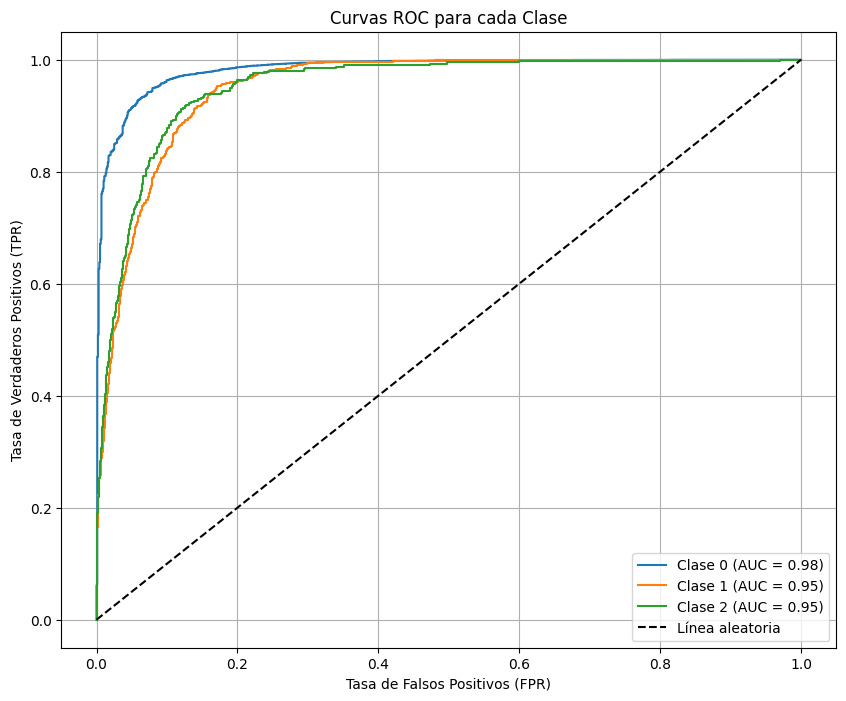

In [144]:
y_real = np.array(df.y_real.tolist())
y_pred = np.array(df.y_pred.tolist())

plt.figure(figsize=(10, 8))

thresholds = []
youden_index = []
best_thresholds = []

for i in range(3):
    fpr, tpr, thresholds = roc_curve(y_real[:, i], y_pred[:, i])
    auc = roc_auc_score(y_real[:, i], y_pred[:, i])
    plt.plot(fpr, tpr, label=f'Clase {i} (AUC = {auc:.2f})')

    specificity = 1 - fpr

    j_index = tpr + specificity - 1
    best_threshold = thresholds[np.argmax(j_index)]

    best_thresholds.append(best_threshold)
    youden_index.append(np.max(j_index))

    print(f"Clase {i}: Youden's Index = {youden_index[i]:.2f}, Best threshold = {best_threshold:.2f}")

plt.plot([0, 1], [0, 1], 'k--', label='Línea aleatoria')

plt.title('Curvas ROC para cada Clase')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.legend(loc="lower right")
plt.grid(True)

plt.show()


Matriz de Confusión para la Clase 0:
[[ 940   56]
 [ 531 6155]]

Matriz de Confusión para la Clase 1:
[[6980  116]
 [ 347  239]]

Matriz de Confusión para la Clase 2:
[[7136  136]
 [ 212  198]]
Clase 0: Precision = 0.99, Recall = 0.92, F1 Score = 0.95, Accuracy = 0.92
Clase 1: Precision = 0.67, Recall = 0.41, F1 Score = 0.51, Accuracy = 0.94
Clase 2: Precision = 0.59, Recall = 0.48, F1 Score = 0.53, Accuracy = 0.95


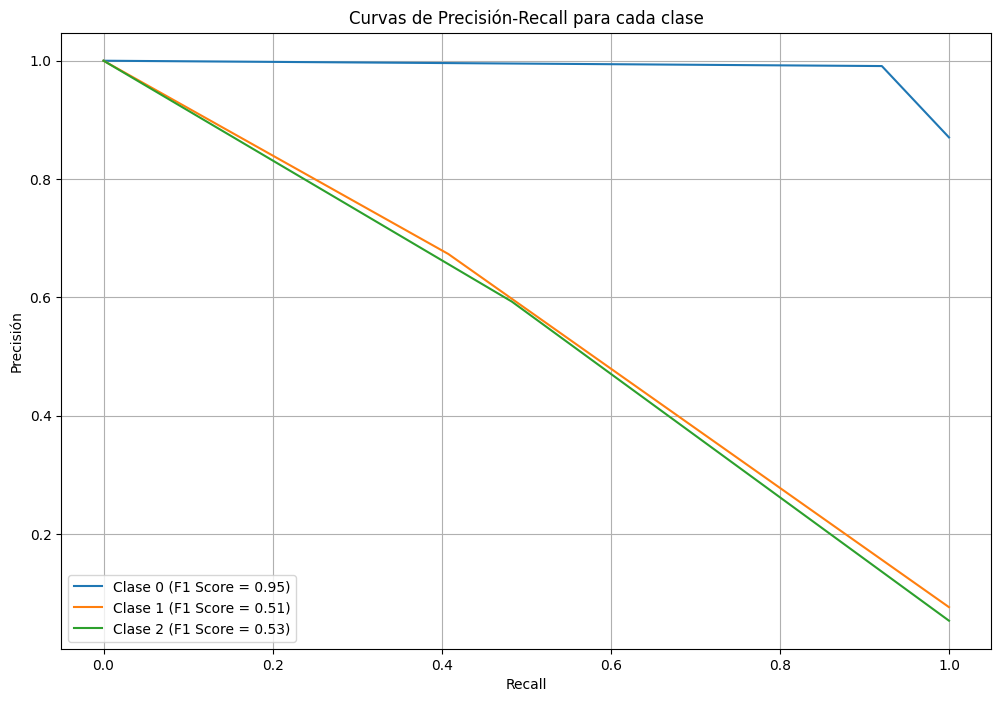

In [147]:
precision_scores = []
recall_scores = []
f1_scores = []
accuracies = []
fpr, tpr, thresholds = roc_curve(y_real.ravel(), y_pred.ravel())

y_pred_binarized = np.copy(y_pred)
for i in range(3):
    y_pred_binarized[:, i] = (y_pred[:, i] >= youden_index[i]).astype(int)

for i in range(3):
    print(f"\nMatriz de Confusión para la Clase {i}:")
    cm = confusion_matrix(y_real[:, i], y_pred_binarized[:, i])
    print(cm)

for i in range(3):
    precision = precision_score(y_real[:, i], y_pred_binarized[:, i])
    recall = recall_score(y_real[:, i], y_pred_binarized[:, i])
    f1 = f1_score(y_real[:, i], y_pred_binarized[:, i])
    accuracy = accuracy_score(y_real[:, i], y_pred_binarized[:, i])

    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    accuracies.append(accuracy)

    print(f"Clase {i}: Precision = {precision:.2f}, Recall = {recall:.2f}, F1 Score = {f1:.2f}, Accuracy = {accuracy:.2f}")

plt.figure(figsize=(12, 8))

for i in range(3):
    precision, recall, _ = precision_recall_curve(y_real[:, i], y_pred_binarized[:, i])
    plt.plot(recall, precision, label=f'Clase {i} (F1 Score = {f1_scores[i]:.2f})')

plt.title('Curvas de Precisión-Recall para cada clase')
plt.xlabel('Recall')
plt.ylabel('Precisión')
plt.legend(loc='best')
plt.grid(True)
plt.show()